In [1]:
# ✅ Step 1: Install dependencies (if needed)
!pip install xgboost shap scikit-learn imbalanced-learn

# ✅ Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")


## Load dataset


In [2]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])
print("Shape of DataFrame after loading:", df.shape)
df.head()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape of DataFrame after loading: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##Explore the dataset

In [3]:
# Basic info
df.info()
df.describe()

# Check for missing values
df.isnull().sum()

# Quick look at categorical columns
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"{col}:\n{df[col].value_counts()}\n")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


##Data cleaning and preprocessing

In [4]:
# Drop customerID (not useful for prediction)
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# Convert TotalCharges to numeric (some might be spaces)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

# Drop rows with NaN in Churn column after encoding
df.dropna(subset=['Churn'], inplace=True)

# Encode categorical features (excluding 'Churn' and 'tenure_group' for now)
categorical_cols_for_encoding = [col for col in df.select_dtypes(include='object').columns if col not in ['Churn', 'tenure_group']]

# Apply one-hot encoding to the selected categorical columns
df = pd.get_dummies(df, columns=categorical_cols_for_encoding, drop_first=True)

print("Shape of DataFrame after initial cleaning and encoding:", df.shape)

Shape of DataFrame after initial cleaning and encoding: (7043, 31)


In [5]:
print(df.columns.tolist())


['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


##Feature engineering

In [6]:
# -------------------------------
# 1️ Feature Engineering Block
# -------------------------------

# 1. Tenure groups (categorical)
df['tenure_group'] = pd.cut(
    df['tenure'],
    bins=[0, 12, 24, 48, 60, 72],
    labels=['0-12','13-24','25-48','49-60','61-72']
)

# Fill potential NaNs created by pd.cut (for values outside bins)
df['tenure_group'] = df['tenure_group'].cat.add_categories('Unknown').fillna('Unknown')


# 2. Count number of active services per customer
# Use one-hot encoded columns for services
service_cols_encoded = [col for col in df.columns if any(s in col for s in ['PhoneService_', 'MultipleLines_', 'InternetService_', 'OnlineSecurity_', 'OnlineBackup_', 'DeviceProtection_', 'TechSupport_', 'StreamingTV_', 'StreamingMovies_'])]

# Sum the one-hot encoded service columns to get the count of active services
df['services_count'] = df[service_cols_encoded].sum(axis=1)

# 3. Contract flags
# Use one-hot encoded columns for Contract
df['is_long_contract'] = df[['Contract_One year', 'Contract_Two year']].sum(axis=1).clip(upper=1)

# Check if 'Contract_Month-to-month' exists before accessing
if 'Contract_Month-to-month' in df.columns:
    df['is_monthly_contract'] = df['Contract_Month-to-month']
else:
    # If drop_first=True was used and Month-to-month is the dropped category,
    # it's the case where both 'One year' and 'Two year' are False
    df['is_monthly_contract'] = ((df['Contract_One year'] == 0) & (df['Contract_Two year'] == 0)).astype(int)


# 4. Automatic payment flag
auto_pay_cols = [col for col in df.columns if 'automatic' in col.lower()]
if auto_pay_cols:
    df['auto_pay'] = df[auto_pay_cols].sum(axis=1).clip(upper=1)
else:
    df['auto_pay'] = 0 # Or handle this case as appropriate if no automatic payment methods exist


# -------------------------------
# 5️ Quick check: show new columns
# -------------------------------
print(df[['tenure_group','services_count','is_long_contract','is_monthly_contract','auto_pay']].head())

# -------------------------------
# 6️ One-hot encode tenure_group after feature engineering
# -------------------------------
df = pd.get_dummies(df, columns=['tenure_group'], drop_first=True)

print("Shape of DataFrame after feature engineering and encoding tenure_group:", df.shape)

  tenure_group  services_count  is_long_contract  is_monthly_contract  \
0         0-12               2                 0                    1   
1        25-48               3                 1                    0   
2         0-12               3                 0                    1   
3        25-48               4                 1                    0   
4         0-12               2                 0                    1   

   auto_pay  
0         0  
1         0  
2         0  
3         0  
4         0  
Shape of DataFrame after feature engineering and encoding tenure_group: (7043, 40)


##Split data

In [7]:
# Features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Handle class imbalance

In [8]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_res.value_counts())


Original class distribution:
 Churn
0    4139
1    1495
Name: count, dtype: int64
After SMOTE:
 Churn
0    4139
1    4139
Name: count, dtype: int64


## Train Model

In [9]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_res, y_train_res)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Evaluate Models

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1035
           1       0.57      0.56      0.56       374

    accuracy                           0.77      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.77      0.77      0.77      1409



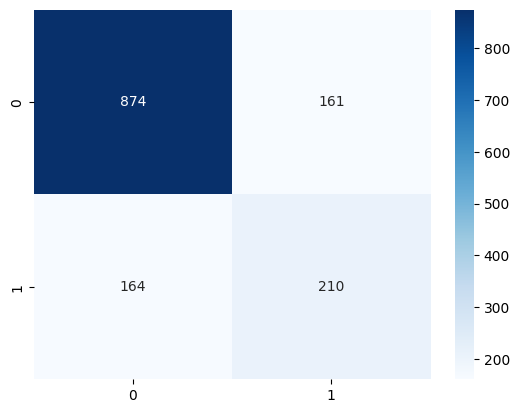

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1035
           1       0.57      0.56      0.56       374

    accuracy                           0.77      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.77      0.77      0.77      1409



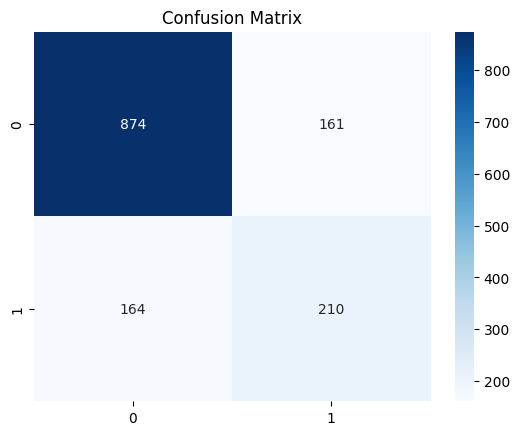

ROC-AUC Score: 0.8127386395928594


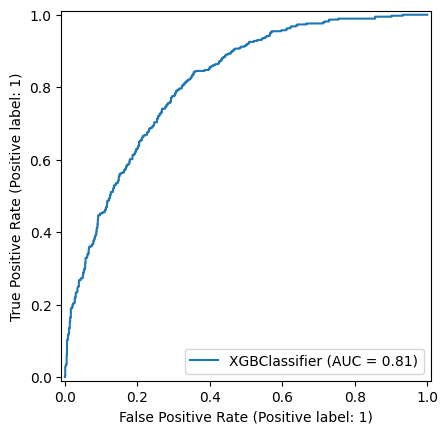

In [10]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] # probability of churn

    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.show()

    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()


    #ROC -AUC
    roc_score = roc_auc_score(y_test, y_prob)
    print(f"ROC-AUC Score: {roc_score}")
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.show()

# Example
evaluate_model(xgb, X_test, y_test)


## Feature Importance.. check which features afect churn most


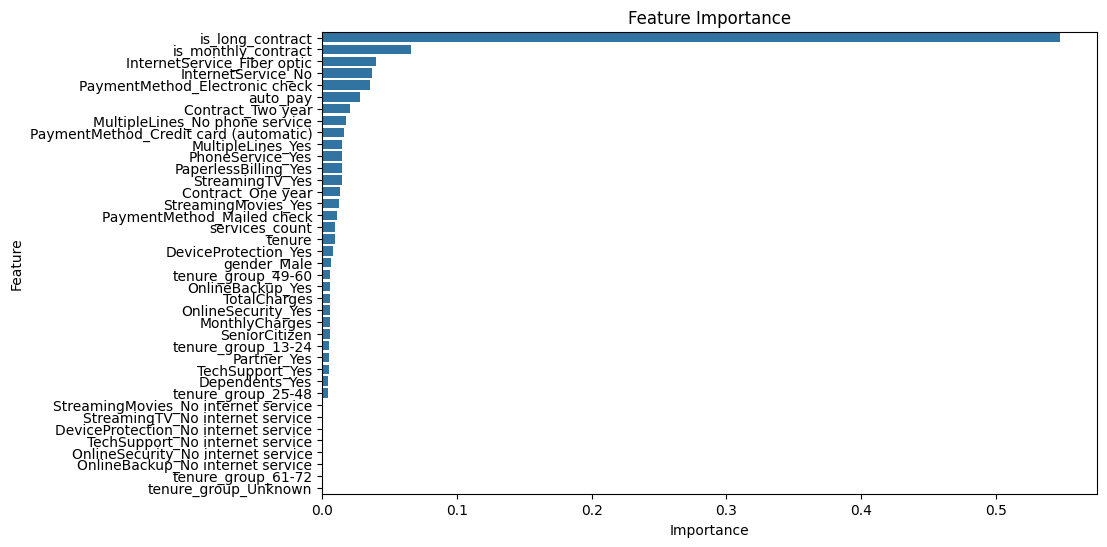

In [11]:
feat_importance = pd.DataFrame({'Feature': X.columns, 'Importance': xgb.feature_importances_})
feat_importance = feat_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title("Feature Importance")
plt.show()


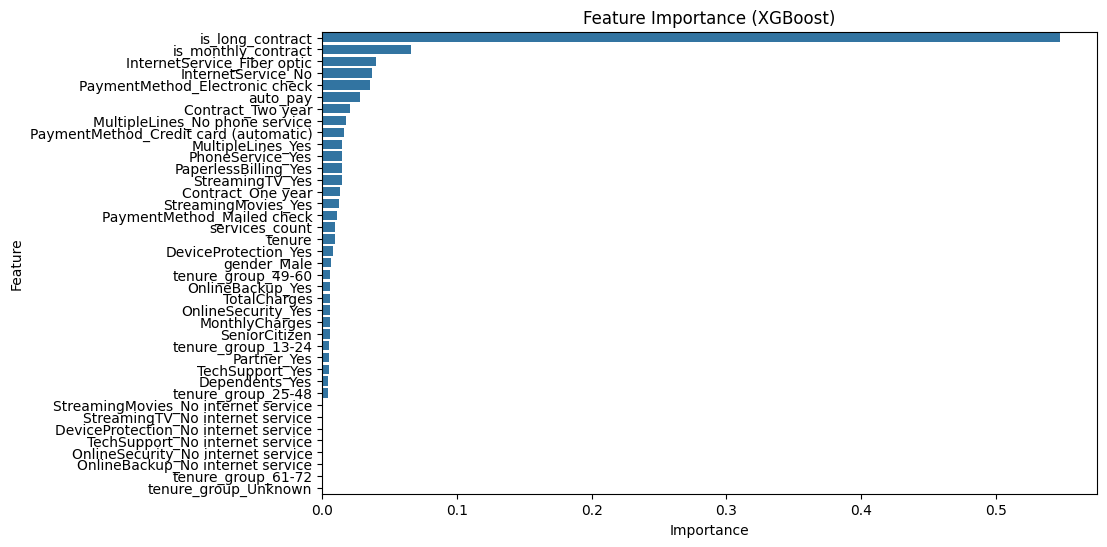

In [12]:
import pandas as pd

feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title("Feature Importance (XGBoost)")
plt.show()


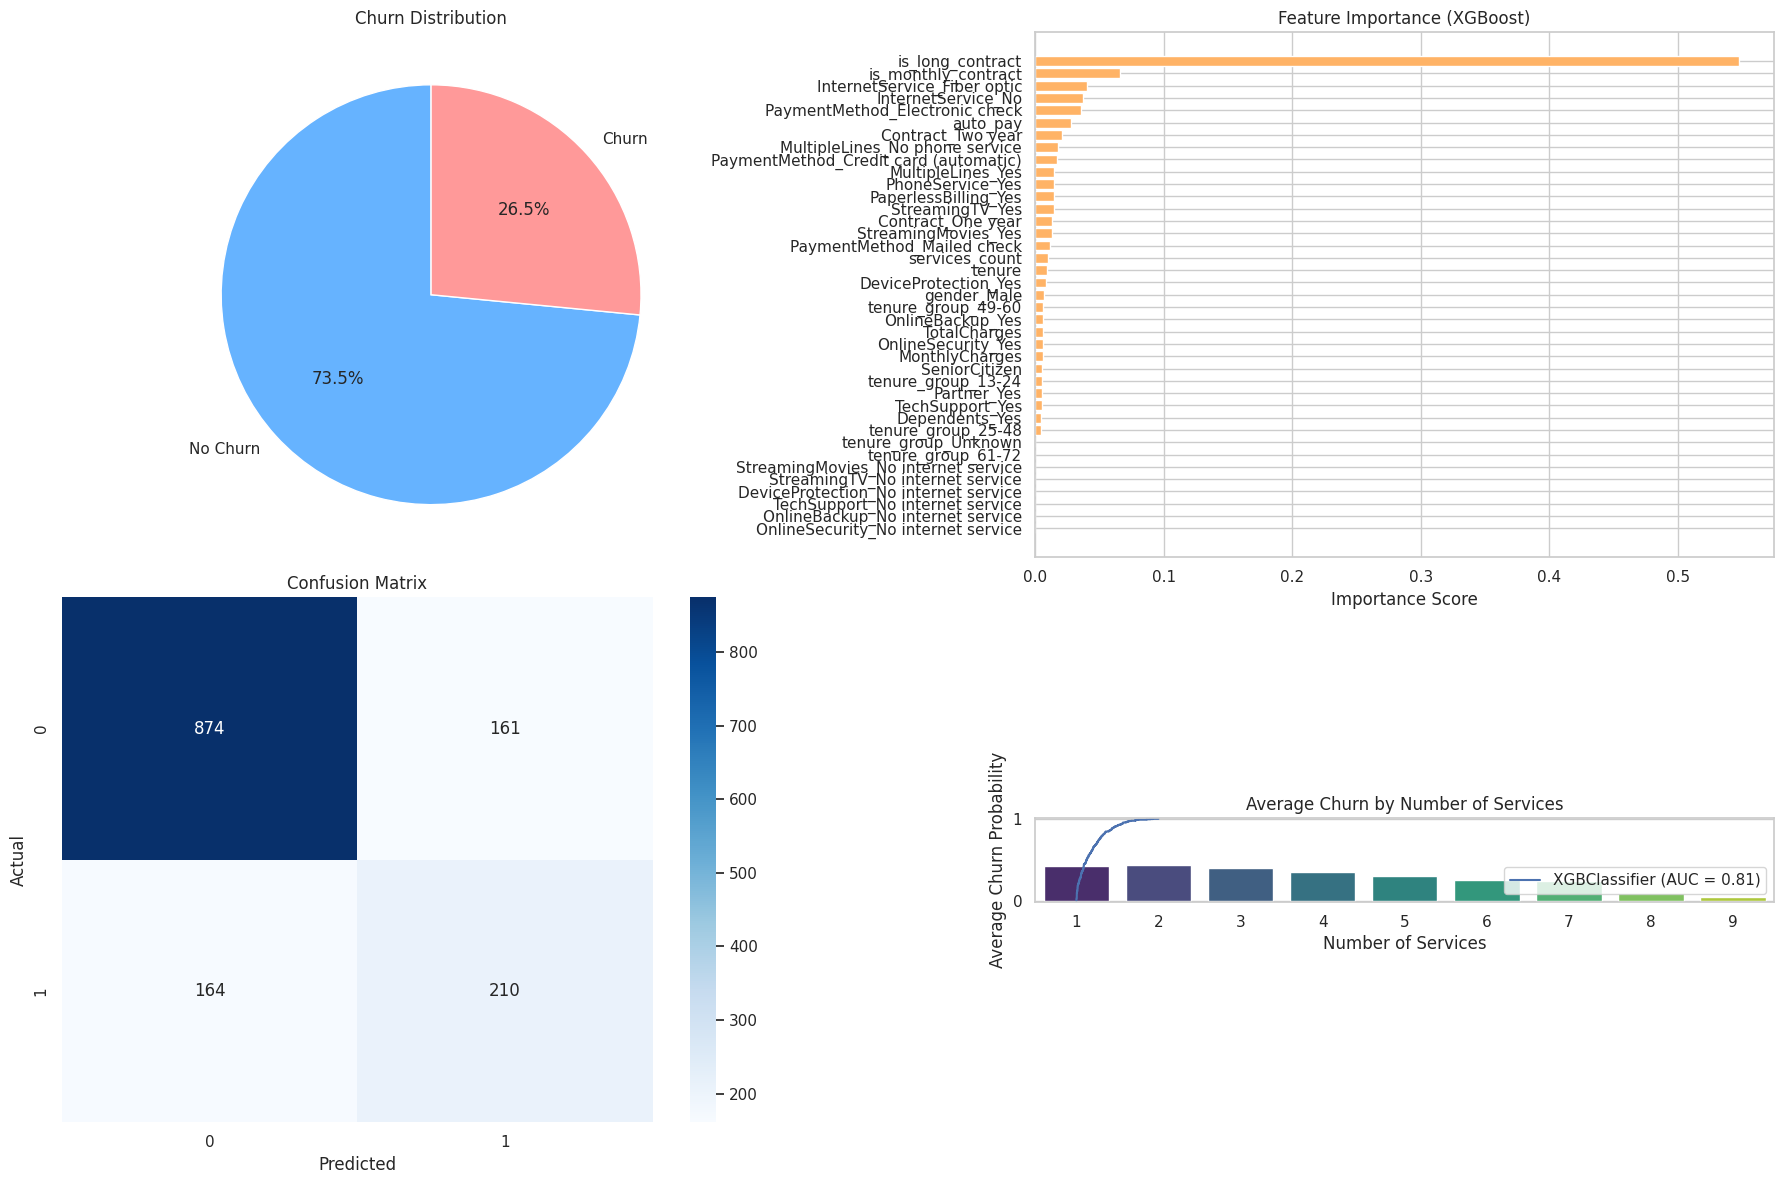

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay

# Set style
sns.set(style="whitegrid")

# Create a 2x2 dashboard
fig, axes = plt.subplots(2, 2, figsize=(18,12))

# ----------------------------
# 1. Churn Distribution Pie Chart
# ----------------------------
churn_counts = df['Churn'].value_counts()
axes[0,0].pie(churn_counts, labels=['No Churn','Churn'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
axes[0,0].set_title("Churn Distribution")

# ----------------------------
# 2. Feature Importance (XGBoost)
# ----------------------------
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=True)

axes[0,1].barh(feat_importance['Feature'], feat_importance['Importance'], color='#ffb366')
axes[0,1].set_title("Feature Importance (XGBoost)")
axes[0,1].set_xlabel("Importance Score")

# ----------------------------
# 3. Confusion Matrix (XGBoost)
# ----------------------------
y_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title("Confusion Matrix")
axes[1,0].set_xlabel("Predicted")
axes[1,0].set_ylabel("Actual")

# ----------------------------
# 4. ROC Curve
# ----------------------------
RocCurveDisplay.from_estimator(xgb, X_test, y_test, ax=axes[1,1])
axes[1,1].set_title("ROC Curve (XGBoost)")

# 5️. Services Count vs Churn
sns.barplot(x='services_count', y='Churn', data=df, ci=None, ax=axes[1,1], palette='viridis')
axes[1,1].set_title("Average Churn by Number of Services")
axes[1,1].set_xlabel("Number of Services")
axes[1,1].set_ylabel("Average Churn Probability")

# Hide the empty 6th subplot
#axes[1,2].axis('off')

plt.tight_layout()
plt.show()


## final dashboard

Dashboard saved as: churn_dashboard.png and churn_dashboard.pdf


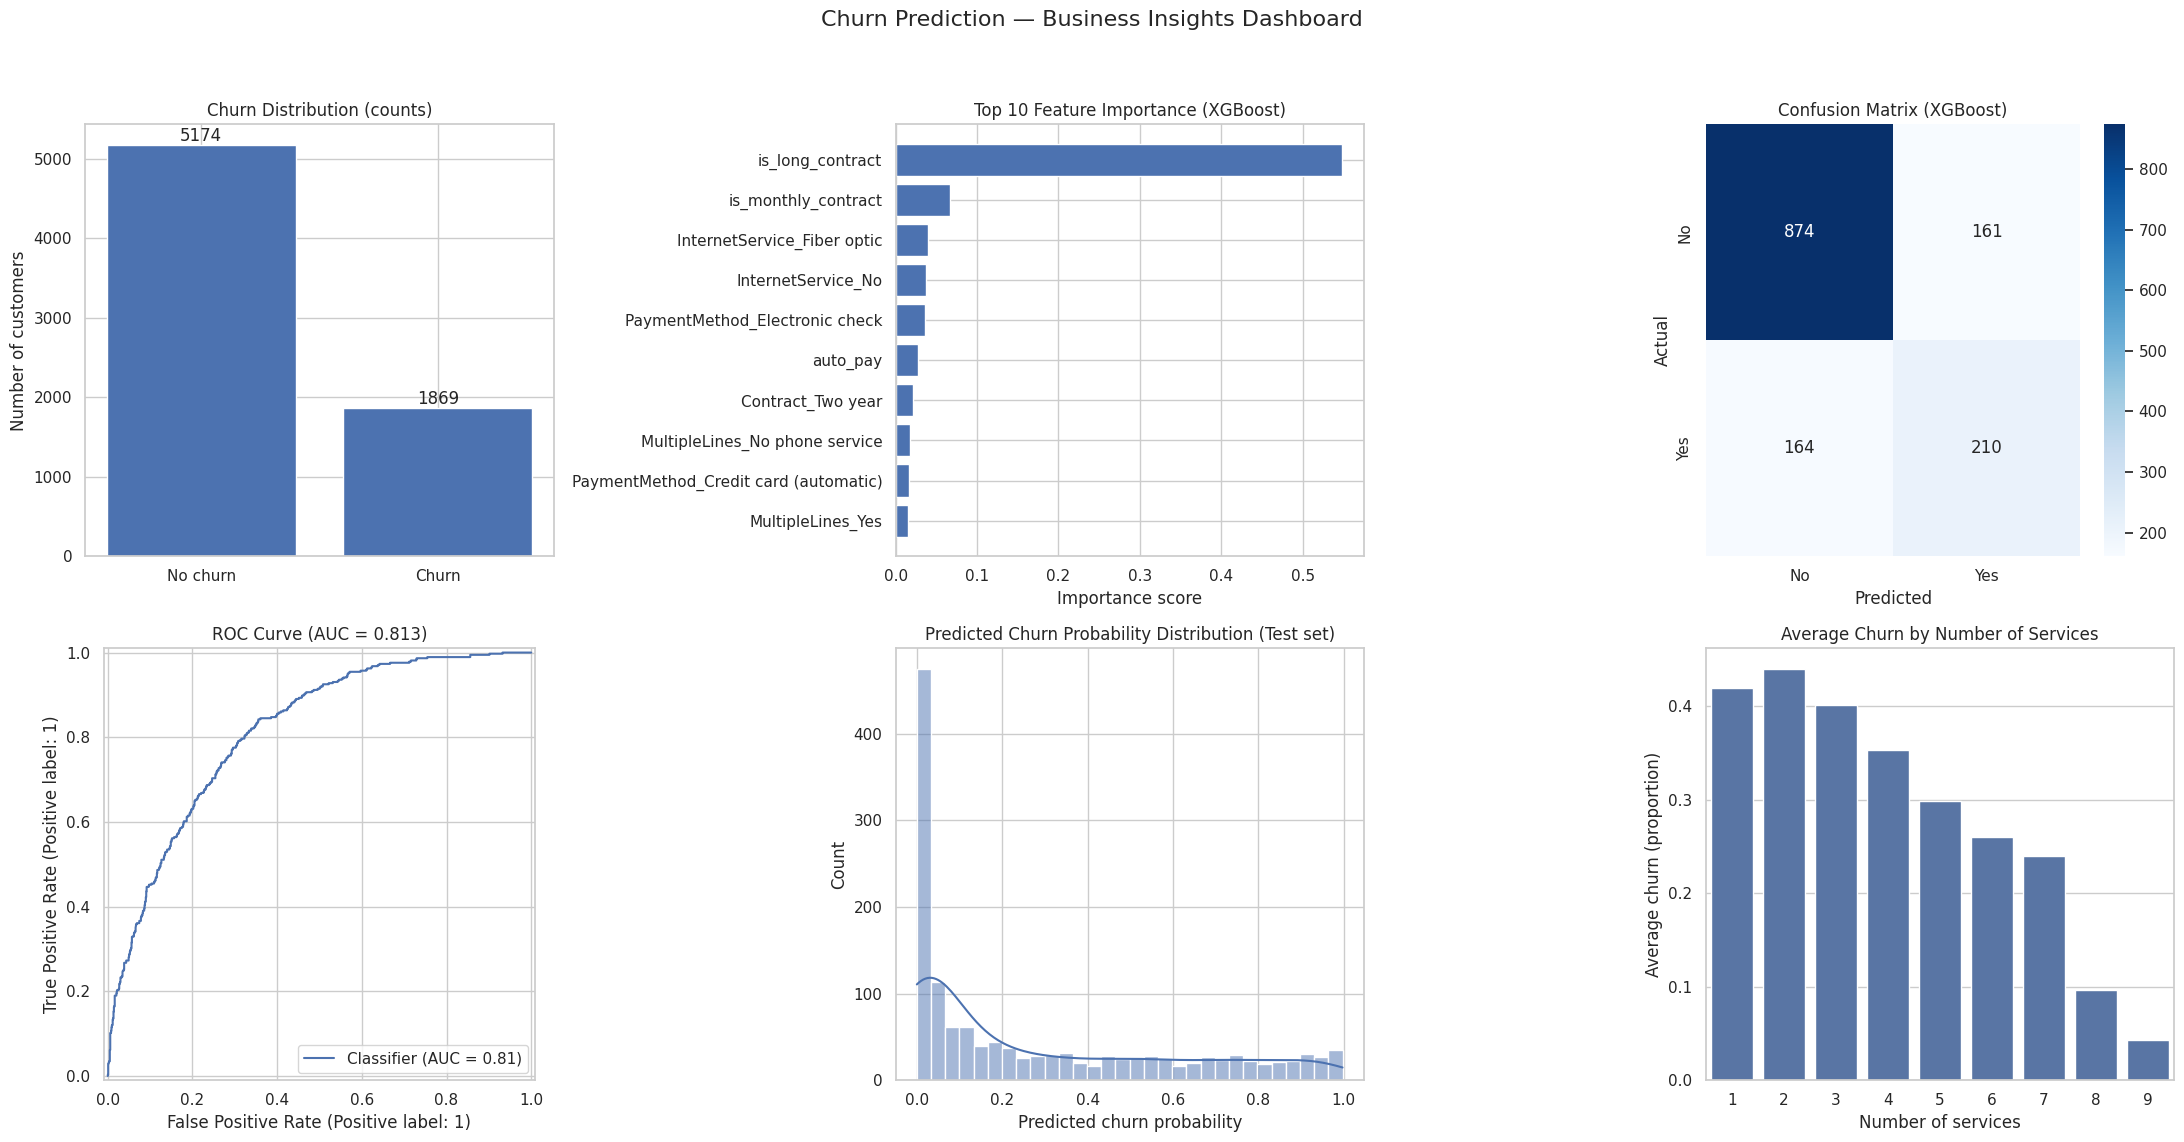

In [14]:
# Final Business Insights Dashboard (run after models are trained)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd

sns.set(style="whitegrid")

# Safety checks
required_vars = ['df', 'X', 'X_test', 'y_test', 'xgb']
for v in required_vars:
    if v not in globals():
        raise RuntimeError(f"Required variable '{v}' not found. Make sure you've run training and defined X_test, y_test, and xgb.")

# Predictions & probabilities
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

# If you want churn probability for whole dataset:
if 'X' in globals():
    churn_prob_all = xgb.predict_proba(X)[:, 1]
else:
    churn_prob_all = None

# Feature importance
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values(by='importance', ascending=True)

# Prepare figure: 2 rows x 3 cols, use one empty if not needed
fig, axes = plt.subplots(2, 3, figsize=(22, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# 1) Churn distribution (counts)
ax = axes[0, 0]
churn_counts = df['Churn'].value_counts().sort_index()  # 0 then 1
labels = ['No churn', 'Churn']
ax.bar(labels, churn_counts.values)
ax.set_title("Churn Distribution (counts)")
ax.set_ylabel("Number of customers")
for i, v in enumerate(churn_counts.values):
    ax.text(i, v + max(churn_counts.values) * 0.01, str(v), ha='center')

# 2) Feature importance (top 10)
ax = axes[0, 1]
top_n = 10
top = feat_imp.tail(top_n)
ax.barh(top['feature'], top['importance'])
ax.set_title(f"Top {top_n} Feature Importance (XGBoost)")
ax.set_xlabel("Importance score")

# 3) Confusion matrix heatmap
ax = axes[0, 2]
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title("Confusion Matrix (XGBoost)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])

# 4) ROC curve with AUC
ax = axes[1, 0]
RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax)
auc_score = roc_auc_score(y_test, y_prob)
ax.set_title(f"ROC Curve (AUC = {auc_score:.3f})")

# 5) Churn probability distribution (predicted)
ax = axes[1, 1]
sns.histplot(y_prob, bins=30, kde=True, ax=ax)
ax.set_title("Predicted Churn Probability Distribution (Test set)")
ax.set_xlabel("Predicted churn probability")
ax.set_ylabel("Count")

# 6) Services count vs avg churn probability (if column exists)
ax = axes[1, 2]
if 'services_count' in df.columns:
    # compute average churn by services_count (use whole df if churn numeric)
    temp = df.copy()
    # if churn is numeric 0/1 else map
    if temp['Churn'].dtype == 'object':
        temp['Churn'] = temp['Churn'].map({'Yes':1, 'No':0})
    svc = temp.groupby('services_count')['Churn'].mean().reset_index()
    sns.barplot(x='services_count', y='Churn', data=svc, ax=ax)
    ax.set_title("Average Churn by Number of Services")
    ax.set_xlabel("Number of services")
    ax.set_ylabel("Average churn (proportion)")
else:
    ax.axis('off')
    ax.text(0.5, 0.5, 'services_count not found', ha='center', va='center')

plt.suptitle("Churn Prediction — Business Insights Dashboard", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save outputs
dashboard_png = "churn_dashboard.png"
dashboard_pdf = "churn_dashboard.pdf"
fig.savefig(dashboard_png, dpi=300, bbox_inches='tight')
fig.savefig(dashboard_pdf, dpi=300, bbox_inches='tight')

print(f"Dashboard saved as: {dashboard_png} and {dashboard_pdf}")

plt.show()

## pdf

In [15]:
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
import textwrap

report_file = "churn_report.pdf"
summary_text = """
Churn Prediction System — Internship Project (Task 2)

Objective:
Build a churn prediction model using the Telco dataset to identify customers likely to leave,
and provide business insights to reduce churn.

Key steps completed:
- Data cleaning and preprocessing
- Feature engineering: tenure groups, services_count, contract/payment flags
- Handled class imbalance with SMOTE
- Trained Logistic Regression, Random Forest, and XGBoost models
- Evaluated models with confusion matrix, ROC-AUC, and classification metrics
- Created feature importance and dashboard visualizations
"""

# Short recommendations
recommendations = [
    "Focus retention offers on month-to-month customers and those with few services.",
    "Promote automatic payment and long-term contract incentives to at-risk customers.",
    "Investigate service quality for fiber-optic internet users (high churn risk in many datasets)."
]

with PdfPages(report_file) as pdf:
    # Page 1: Title + Summary
    fig1 = plt.figure(figsize=(8.27, 11.69))  # A4 portrait
    fig1.clf()
    plt.axis('off')
    plt.text(0.5, 0.9, "Churn Prediction System — Task 2", ha='center', fontsize=18, weight='bold')
    plt.text(0.5, 0.86, "Machine Learning Intern — FutureInterns", ha='center', fontsize=12)
    plt.text(0.05, 0.74, "Executive Summary:", fontsize=12, weight='bold')
    wrapped = "\n".join(textwrap.wrap(summary_text.strip(), 100))
    plt.text(0.05, 0.62, wrapped, fontsize=10)
    plt.text(0.05, 0.10, "Key recommendations:", fontsize=12, weight='bold')
    y = 0.08
    for rec in recommendations:
        plt.text(0.06, y, f"- {rec}", fontsize=10)
        y -= 0.03
    pdf.savefig(fig1, bbox_inches='tight')
    plt.close(fig1)

    # Page 2: Dashboard image
    fig2 = plt.figure(figsize=(11.69, 8.27))
    plt.axis('off')
    # Insert the previously saved dashboard PNG
    img = Image.open(dashboard_png)
    plt.imshow(img)
    plt.axis('off')
    pdf.savefig(fig2, bbox_inches='tight')
    plt.close(fig2)

    # Page 3: Metrics + model summary
    # Compute classification report for xgb
    from sklearn.metrics import classification_report
    cr = classification_report(y_test, y_pred, output_dict=True)
    cr_df = pd.DataFrame(cr).transpose()

    fig3 = plt.figure(figsize=(8.27, 11.69))
    fig3.clf()
    plt.axis('off')
    plt.text(0.5, 0.95, "Model Evaluation Summary", ha='center', fontsize=14, weight='bold')
    # Print AUC
    plt.text(0.05, 0.88, f"Model: XGBoost (final chosen model)", fontsize=11)
    plt.text(0.05, 0.85, f"ROC-AUC (test set): {auc_score:.3f}", fontsize=11)
    plt.text(0.05, 0.81, "Classification report (precision/recall/f1):", fontsize=11, weight='bold')

    # Render classification report table as text block
    table_text = cr_df.round(3).to_string()
    plt.text(0.05, 0.75, table_text, fontsize=8, family='monospace')

    plt.text(0.05, 0.28, "Notes:", fontsize=11, weight='bold')
    plt.text(0.05, 0.24, "- Models trained: Logistic Regression, Random Forest, XGBoost", fontsize=9)
    plt.text(0.05, 0.20, "- Data balance: SMOTE applied to training set", fontsize=9)
    plt.text(0.05, 0.16, "- Recommendations: see page 1", fontsize=9)

    pdf.savefig(fig3, bbox_inches='tight')
    plt.close(fig3)

print(f"Multi-page report saved as: {report_file}")


Multi-page report saved as: churn_report.pdf


## per customer churn

In [16]:
# Export churn probabilities (whole dataset)
if 'customerID' in df.columns:
    id_col = df['customerID']
else:
    id_col = df.index

probs = xgb.predict_proba(X)[:, 1]
out = pd.DataFrame({
    'customer_id': id_col,
    'predicted_churn_probability': probs
})
out.to_csv("churn_probabilities.csv", index=False)
print("Saved churn_probabilities.csv")


Saved churn_probabilities.csv
